In [30]:
import time
import sys
import matplotlib.pyplot as plt
import math
import sympy as sp
import backtracking

In [ ]:


def leer_archivo(archivo):
    
    try:
        with open(archivo, 'r') as f:
            secciones = f.read().strip().split("\n\n") 

        demandas_filas = [int(x) for x in secciones[0].splitlines() if not x.startswith("#")]
        demandas_columnas = [int(x) for x in secciones[1].splitlines() if not x.startswith("#")]
        barcos = [int(x) for x in secciones[2].splitlines() if not x.startswith("#")]

    except FileNotFoundError:
        print(f"Error: El archivo '{archivo}' no existe.")
        sys.exit(1)

    return demandas_filas, demandas_columnas, barcos

def crear_tablero(n, m):
    """Crea un tablero vacío de n x m"""
    return [[0] * m for _ in range(n)]

def colocar_barco(tablero, fila, col, barco, horizontal):
    """Coloca un barco de tamaño 'barco' en el tablero directamente (sin crear una copia)"""
    if horizontal:
        for c in range(col, col + barco):
            tablero[fila][c] = 1
    else:
        for f in range(fila, fila + barco):
            tablero[f][col] = 1



def deshacer_barco(tablero, fila, col, barco, horizontal):
    """Deshace la colocación de un barco en el tablero."""
    if horizontal:
        for c in range(col, col + barco):
            tablero[fila][c] = 0
    else:
        for f in range(fila, fila + barco):
            tablero[f][col] = 0

def es_posicion_valida(tablero, fila, col, barco, horizontal, demandas_columnas, demandas_filas):
    """
    Verifica si es válido colocar un barco en una posición específica.
    """
    n, m = len(tablero), len(tablero[0])

    if horizontal:
        # Verificar si el barco cabe horizontalmente
        if col + barco > m:
            return False
        # Verificar demandas de la fila
        if sum(tablero[fila][c] for c in range(m)) + barco > demandas_filas[fila]:
            return False
        # Verificar demandas de las columnas afectadas
        for c in range(col, col + barco):
            if sum(tablero[f][c] for f in range(n)) + 1 > demandas_columnas[c]:
                return False
        # Verificar adyacencias
        for c in range(max(0, col - 1), min(m, col + barco + 1)):
            for f in range(max(0, fila - 1), min(n, fila + 2)):
                if tablero[f][c] != 0:
                    return False
    else:
        # Verificar si el barco cabe verticalmente
        if fila + barco > n:
            return False
        # Verificar demandas de la columna
        if sum(tablero[f][col] for f in range(n)) + barco > demandas_columnas[col]:
            return False
        # Verificar demandas de las filas afectadas
        for f in range(fila, fila + barco):
            if sum(tablero[f][c] for c in range(m)) + 1 > demandas_filas[f]:
                return False
        # Verificar adyacencias
        for f in range(max(0, fila - 1), min(n, fila + barco + 1)):
            for c in range(max(0, col - 1), min(m, col + 2)):
                if tablero[f][c] != 0:
                    return False

    return True

def calcular_demanda_cumplida(tablero):
    """
    Calcula la demanda cumplida como el doble de la cantidad de casillas ocupadas por barcos.
    """
    casillas_ocupadas = sum(sum(1 for celda in fila if celda != 0) for fila in tablero)
    return casillas_ocupadas * 2

def calcular_demanda_obtenible(tablero, demandas_filas, demandas_columnas):
    """
    Calcula la demanda máxima obtenible desde el estado actual.
    Considera todas las casillas aún disponibles en el tablero.
    """
    n, m = len(tablero), len(tablero[0])
    demanda_restante_filas = [demandas_filas[i] - sum(tablero[i]) for i in range(n)]
    demanda_restante_columnas = [demandas_columnas[j] - sum(tablero[i][j] for i in range(n)) for j in range(m)]

    # Solo considerar valores positivos (demandas que aún pueden ser cumplidas)
    maximo_filas = sum(max(0, x) for x in demanda_restante_filas)
    maximo_columnas = sum(max(0, x) for x in demanda_restante_columnas)

    # La demanda obtenible es el mínimo entre filas y columnas restantes
    return min(maximo_filas, maximo_columnas) * 2  # Multiplicar por 2 (cada casilla aporta 2 de demanda)

def ubicar_barcos_backtracking(tablero, barcos, demandas_filas, demandas_columnas, mejor_solucion, mejor_cumplida, demanda_actual,memo, casillas_disponibles):
    """
    Backtracking con poda y verificación de casillas restantes.
    Maximiza la demanda cumplida calculada como casillas ocupadas * 2.
    """
    # Si hay una mejor demanda en este punto, actualizamos la mejor solución
    if demanda_actual > mejor_cumplida[0]:
        mejor_cumplida[0] = demanda_actual
        mejor_solucion[:] = [fila[:] for fila in tablero]  # Guardar la solución actual

    # Caso base: si no hay más barcos
    if not barcos:
        return

    # Calcular contribución máxima posible de los barcos restantes
    contribucion_barcos = sum(barco * 2 for barco in barcos)
    contribucion_casillas = calcular_demanda_obtenible(tablero, demandas_filas, demandas_columnas)

    # La cota superior es el mínimo entre las casillas disponibles y los barcos restantes
    contribucion_maxima_restante = min(contribucion_barcos, contribucion_casillas)

    # Poda: Si la demanda actual más la máxima contribución posible es menor que la mejor encontrada, cortamos
    if demanda_actual + contribucion_maxima_restante <= mejor_cumplida[0]:
        return

    # Intentar colocar el barco en todas las casillas disponibles
    for fila, col in casillas_disponibles:
        for horizontal in [True, False]:
            # Ignorar barcos de tamaño 1 en orientación vertical
            if not horizontal and barcos[0] == 1:
                continue

            # Verificar si la casilla ya está ocupada
            if tablero[fila][col] != 0:
                continue

            # Verificar si se puede colocar el barco en la posición actual
            if es_posicion_valida(tablero, fila, col, barcos[0], horizontal, demandas_columnas, demandas_filas):
                barco = barcos.pop(0)  # Sacamos el primer barco de la lista
                colocar_barco(tablero, fila, col, barco, horizontal)  # Colocamos el barco

                # Actualizar las casillas disponibles y la demanda cumplida
                nuevas_casillas = actualizar_casillas_disponibles(casillas_disponibles, fila, col, barco, horizontal, tablero)
                nueva_demanda = demanda_actual + barco * 2

                # Continuar con el siguiente barco
                ubicar_barcos_backtracking(
                    tablero, barcos, demandas_filas, demandas_columnas,
                    mejor_solucion, mejor_cumplida, nueva_demanda,memo, nuevas_casillas
                )

                # Deshacer la colocación (backtrack)
                deshacer_barco(tablero, fila, col, barco, horizontal)
                barcos.insert(0, barco)  # Restaurar el barco a la lista

    # Poda: También podemos omitir este barco (no colocarlo)
    ubicar_barcos_backtracking(
        tablero, barcos[1:], demandas_filas, demandas_columnas,
        mejor_solucion, mejor_cumplida, demanda_actual,memo, casillas_disponibles
    )

def calcular_casillas_disponibles(n, m, demandas_filas, demandas_columnas):
    """
    Calcula las casillas disponibles para colocar barcos.
    Solo se consideran filas y columnas que tienen demanda restante.
    """
    casillas_disponibles = set()

    # Consideramos solo las filas que tienen demanda restante
    for fila in range(n):
        if demandas_filas[fila] > 0:  # Si la fila tiene demanda restante
            for col in range(m):
                if demandas_columnas[col] > 0:  # Si la columna tiene demanda restante
                    casillas_disponibles.add((fila, col))

    return casillas_disponibles

def actualizar_casillas_disponibles(casillas_disponibles, fila, col, barco, horizontal, tablero):
    """
    Actualiza las casillas disponibles después de colocar un barco.
    Elimina las casillas ocupadas y las adyacentes.
    """
    nuevas_casillas = set(casillas_disponibles)
    n, m = len(tablero), len(tablero[0])

    if horizontal:
        # Eliminar casillas ocupadas y adyacentes horizontalmente
        for c in range(max(0, col - 1), min(m, col + barco + 1)):
            for f in range(max(0, fila - 1), min(n, fila + 2)):
                nuevas_casillas.discard((f, c))
    else:
        # Eliminar casillas ocupadas y adyacentes verticalmente
        for f in range(max(0, fila - 1), min(n, fila + barco + 1)):
            for c in range(max(0, col - 1), min(m, col + 2)):
                nuevas_casillas.discard((f, c))

    return nuevas_casillas

def verificar_filas_columnas(tablero, fila, col, barco, horizontal, demandas_filas, demandas_columnas):
    """
    Verifica si colocar un barco de tamaño 'barco' en la posición (fila, col) con la orientación
    especificada (horizontal o vertical) no excede las demandas de filas y columnas.
    """
    # Comprobamos las demandas antes de colocar el barco
    if horizontal:
        # Verificar si el barco cabe dentro de la fila
        if col + barco > len(tablero[0]):  # Si el barco se sale del tablero horizontalmente
            return False

        # Verificar que no se excedan las demandas de la fila
        if sum(1 for i in range(col, col + barco) if tablero[fila][i] != 0) + barco > demandas_filas[fila]:
            return False

        # Verificar las demandas de las columnas donde se colocará el barco
        for i in range(col, col + barco):
            if sum(1 for j in range(len(tablero)) if tablero[j][i] != 0) + 1 > demandas_columnas[i]:
                return False

    else:  # Orientación vertical
        # Verificar si el barco cabe dentro de la columna
        if fila + barco > len(tablero):  # Si el barco se sale del tablero verticalmente
            return False

        # Verificar las demandas de las filas donde se colocará el barco
        for i in range(fila, fila + barco):
            if sum(1 for j in range(len(tablero[0])) if tablero[i][j] != 0) + 1 > demandas_filas[i]:
                return False

        # Verificar que no se excedan las demandas de la columna
        if sum(1 for i in range(fila, fila + barco) if tablero[i][col] != 0) + barco > demandas_columnas[col]:
            return False

    return True

def calcular_casillas_disponibles(n, m, demandas_filas, demandas_columnas):
    """
    Calcula las casillas disponibles para colocar barcos.
    Solo se consideran filas y columnas que tienen demanda restante.
    """
    casillas_disponibles = set()

    # Consideramos solo las filas que tienen demanda restante
    for fila in range(n):
        if demandas_filas[fila] > 0:  # Si la fila tiene demanda restante
            for col in range(m):
                if demandas_columnas[col] > 0:  # Si la columna tiene demanda restante
                    casillas_disponibles.add((fila, col))

    return casillas_disponibles

def filtrar_barcos_validos(barcos, demandas_filas, demandas_columnas, tablero):
    """
    Filtra los barcos que no pueden entrar en el tablero debido a que exceden la demanda
    de filas o columnas. Se asegura que los barcos solo se incluyan si pueden caber
    en alguna fila o columna sin exceder la demanda.
    """
    barcos_validos = []

    # Para cada barco, intentamos ver si se puede colocar en alguna posición válida
    for barco in barcos:
        puede_colocarse = False

        # Revisamos en todas las filas y columnas para ver si el barco puede caber
        for fila in range(len(tablero)):
            for col in range(len(tablero[0])):
                # Verificamos si el barco puede colocarse de forma horizontal o vertical
                for horizontal in [True, False]:
                    if es_posicion_valida(tablero, fila, col, barco, horizontal, demandas_columnas, demandas_filas):
                        # Verificamos si no se exceden las demandas de filas y columnas
                        if verificar_filas_columnas(tablero, fila, col, barco, horizontal, demandas_filas, demandas_columnas):
                            puede_colocarse = True
                            break

            if puede_colocarse:
                break

        if puede_colocarse:
            barcos_validos.append(barco)

    return sorted(barcos_validos, reverse=True)  # Ordenamos de mayor a menor para intentar colocar los barcos más grandes primero



def resolver_batalla_naval(n, m, barcos, demandas_filas, demandas_columnas):
    """
    Resuelve el problema de batalla naval utilizando backtracking con poda y early stopping.
    Maximiza la demanda cumplida calculada como casillas ocupadas * 2.
    """
    start_time = time.time()
    # Ordenar barcos de mayor a menor
    barcos.sort(reverse=True)

    tablero = [[0 for _ in range(m)] for _ in range(n)]  # Tablero vacío
    # Filtrar los barcos que no pueden entrar en el tablero
    barcos = filtrar_barcos_validos(barcos, demandas_filas, demandas_columnas, tablero)
    mejor_solucion = []  # Almacena la mejor solución encontrada
    mejor_cumplida = [0]  # Inicialmente, la menor cantidad de demanda cumplida
    memo = set()  # Memorización para evitar recalcular estados
    casillas_disponibles = calcular_casillas_disponibles(n, m, demandas_filas, demandas_columnas)

    # Iniciar el backtracking
    ubicar_barcos_backtracking(tablero, barcos, demandas_filas, demandas_columnas, mejor_solucion, mejor_cumplida, 0, memo, casillas_disponibles)

    end_time = time.time()
    elapsed_time = end_time - start_time

    return elapsed_time

Grafico 1

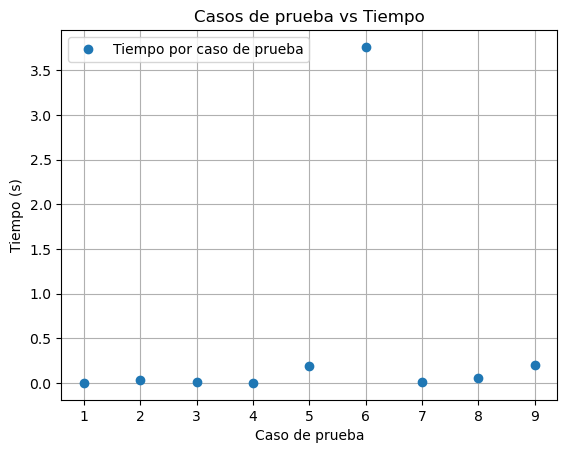

In [ ]:
def plot_bk(tiempos):
    casos = list(range(1, len(tiempos) + 1))  
    
    plt.plot(casos, tiempos, marker='o', linestyle='', label='Tiempo por caso de prueba')  
    plt.xlabel('Caso de prueba')
    plt.ylabel('Tiempo (s)')
    plt.title('Casos de prueba vs Tiempo')
    plt.legend()
    plt.grid(True)
    plt.show()

def casosDePrueba():
    archivos = [
        "3_3_2.txt",
        "5_5_6.txt",
        "8_7_10.txt",
        "10_3_3.txt",
        "10_10_10.txt",
        "12_12_21.txt",
        "15_10_15.txt",
        "20_20_20.txt",
        "20_25_30.txt"
    ]

    tiempos = []
    for archivo in archivos:
        t = 0
        for i in range(0,5):
            demandas_filas, demandas_columnas, barcos = leer_archivo(archivo)
            tiempo = resolver_batalla_naval(len(demandas_filas), len(demandas_columnas), barcos, demandas_filas, demandas_columnas)
            t = t + tiempo
        tiempos.append(t/5)
    
    plot_bk(tiempos)

casosDePrueba()
